In [2]:
!pip3 install matplotlib
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install numpy
!pip3 install nest_asyncio
!pip3 install networkx

  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /tmp/pip-install-u80_cp2e/twint
  Running command git clone -q https://github.com/twintproject/twint.git /tmp/pip-install-u80_cp2e/twint
  Running command git checkout -q origin/master
  Created wheel for twint: filename=twint-2.1.21-py3-none-any.whl size=35011 sha256=0525584d161392bf096f290a224729ba2da9bd3fe0aab5f5c4b33568a4a96c0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gfpjs_q0/wheels/82/67/14/5495652787d3c55288164de4234c0712a1f785a64f61f1ea70
Successfully built twint
  Attempting uninstall: twint
    Found existing installation: twint 2.1.21
    Uninstalling twint-2.1.21:
      Successfully uninstalled twint-2.1.21


In [2]:
import json
import twint
import nest_asyncio
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import networkx as nx
from pandas import Grouper
from pylab import rcParams

# File path

In [3]:
file_path = "../data/twint/data_new2.txt"

# Read in the tweets

In [4]:
tweets = []
with open(file_path) as f:
    for line in f:
        tweet = json.loads(line)
        tweets.append(tweet)
                                  
print("Total number of tweets: %d" % len(tweets))

Total number of tweets: 51853


In [5]:
tweets = [t for t in tweets if t['username'] != 'uber4london']

## 1. Get most popular Uber-related hashtags

### Hashtags and their occurrences

Total number of tweets: 50413
Number of tweets without hashtags: 13


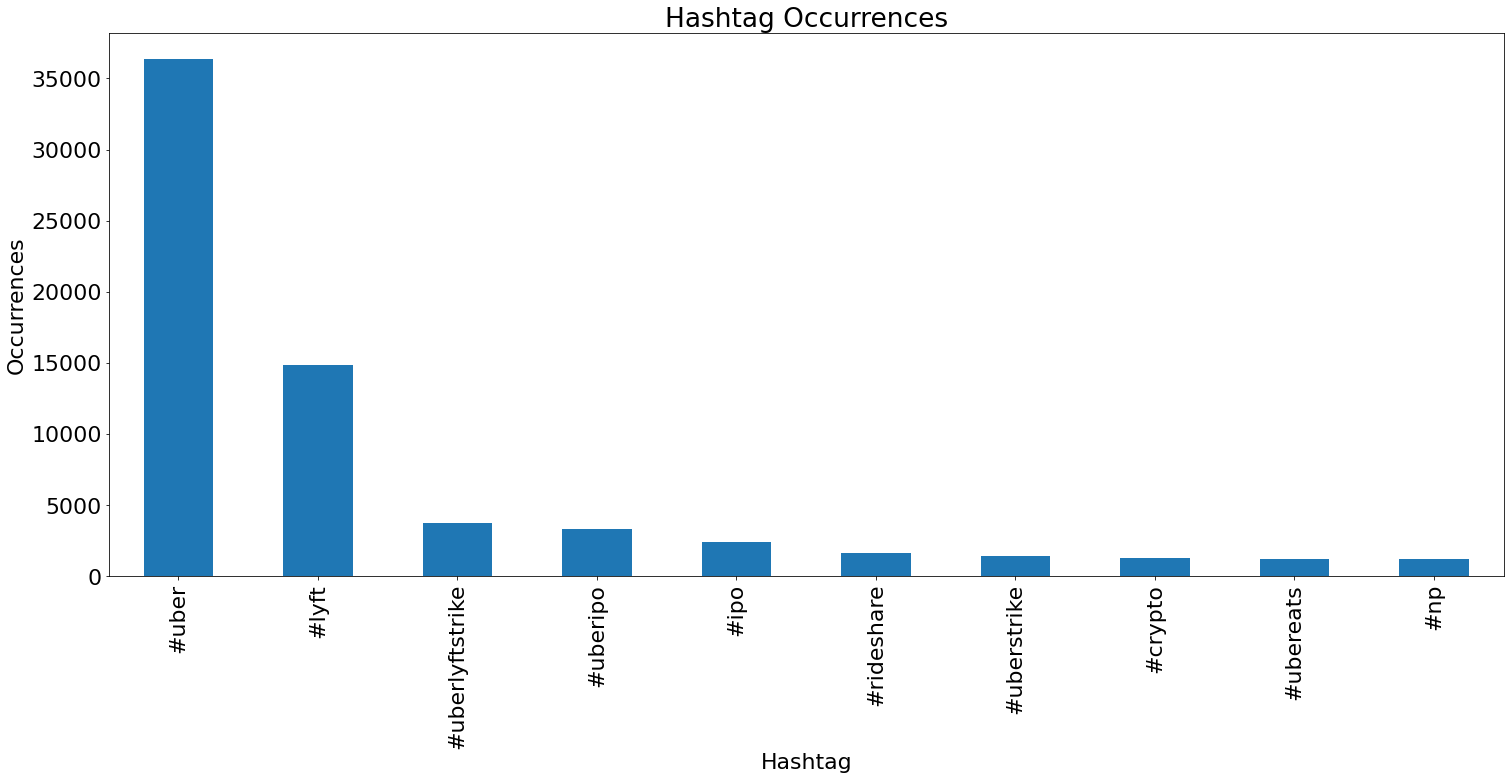

                 count
#uber            36380
#lyft            14880
#uberlyftstrike  3739 
#uberipo         3357 
#ipo             2452 
#rideshare       1623 
#uberstrike      1429 
#crypto          1307 
#ubereats        1256 
#np              1249 


In [6]:
all_hashtags = []
hashtag_pairs = []
tweets_without_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    if len(hashtags) == 0:
        tweets_without_hashtags.append(t)
    pairs = combinations(hashtags, r=2)
    for pair in pairs:
        hashtag_pairs.append(pair)
    for h in hashtags:
        all_hashtags.append(h)
                                  
print("Total number of tweets: %d" % len(tweets))
print("Number of tweets without hashtags: %d" % len(tweets_without_hashtags))
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
ax = hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag Occurrences', figsize=(25, 10),)
ax.set_xlabel('Hashtag')
ax.set_ylabel('Occurrences')
plt.show()
print(hashtag_count_df)

### Hashtag co-ocurrences

In [12]:
pairs_counter = Counter(hashtag_pairs)

hashtags_in_most_common_pairs = []
for t in pairs_counter.most_common(15):
    hashtags_in_most_common_pairs.append(t[0][0])
    hashtags_in_most_common_pairs.append(t[0][1])

hashtags_in_most_common_pairs = list(set(hashtags_in_most_common_pairs))

G = nx.Graph()
G.add_nodes_from(hashtags_in_most_common_pairs)
G.add_weighted_edges_from([(t[0][0], t[0][1], pairs_counter[t[0]]) for t in pairs_counter.most_common(15)])
d = dict(G.degree)
print(d)
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
plt.figure(1, figsize=(20, 15))
plt.margins(0.1, 0.1)
nx.draw_networkx(G,pos, font_weight='bold', node_size=[v * 1800 for v in d.values()], font_color='darkblue', node_color='lightblue', font_size=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, width=40, font_size=15)
plt.title('Hashtag Co-occurrences')
plt.savefig('hashtag_cooccurences.pdf', bbox_inches='tight')
plt.close()

{'#lyft': 3, '#ipo': 1, '#np': 3, '#tradewar': 1, '#ubereats': 1, '#xrpcommunity': 1, '#uber': 11, '#rideshare': 1, '#crypto': 3, '#edm': 3}


## 3. Create their timelines

In [13]:
hashtags_dates = {}
unique_hashtags = set(all_hashtags)
for hashtag in unique_hashtags:
    hashtags_dates[hashtag] = {}

all_dates = [t['date'] for t in tweets]
for d in all_dates:
    for h in hashtags_dates.keys():
        hashtags_dates[h][d] = 0

for t in tweets:
    hashtags = t['hashtags']
    date = t['date']
    for h in hashtags:
        count = hashtags_dates[h][date]
        if count == 0:
            hashtags_dates[h][date] = 1
        else:
            hashtags_dates[h][date] += 1

In [20]:
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(hashtags_dates, orient='index')
df['total'] = df[list(df.columns)].sum(axis=1)
df = df.sort_values(by=['total'], ascending=False)

top_10 = df.head(10).transpose()[::-1].drop(['total'])
top_10 = top_10.transpose()

fig, axes = plt.subplots(5, 2, figsize=(25, 13))
plt.subplots_adjust(hspace=2, wspace=0.2)
fig.suptitle('Hashtag Occurences over Time', fontsize=22)

for i in range(5):
    row = top_10.iloc[[i]]
    ax = row.transpose().plot(ax=axes[i][0], kind='bar', legend=False, fontsize=18)
    ax.set_title(row.index[0], fontsize=20)
    xlabels = [date.split('-')[2] for date in row.columns]
    ax.set_xticklabels(xlabels, fontsize=12)
    
for i in range(5, 10):
    row = top_10.iloc[[i]]
    ax = row.transpose().plot(ax=axes[i-5][1], kind='bar', legend=False, fontsize=18)
    ax.set_title(row.index[0], fontsize=20)
    xlabels = [date.split('-')[2] for date in row.columns]
    ax.set_xticklabels(xlabels, fontsize=12)

plt.savefig('hashtag_occurence_over_time.pdf', bbox_inches='tight')
plt.close()

In [ ]:
ts = [t for t in tweets if '#uk' in t['hashtags']]
print(*[t['tweet'] + '\n' for t in ts])

### 4. Look into the most active users

In [ ]:
nest_asyncio.apply()

most_active_users_counter = Counter([t['username'] for t in tweets])
most_active_users_df = pd.DataFrame.from_dict(most_active_users_counter, orient='index', columns=['tweets']).sort_values(by=['tweets'], ascending=False).head(10)
most_active_users_df.plot(kind='bar', legend=False, title='Number of tweets by user', figsize=(10, 5))

c = twint.Config()
c.Store_object = True
c.Hide_output = True
twint.output.users_list = []

for username in most_active_users_df.index:
    c.Username = username
    twint.run.Lookup(c)
        
most_active_users = twint.output.users_list
most_active_users_df = pd.DataFrame({'username': [user.username for user in most_active_users],
                         'tweets': [most_active_users_counter[user.username.lower()] for user in most_active_users],
                         'name': [user.name for user in most_active_users],
                         'followers': [user.followers for user in most_active_users],
                         'following': [user.following for user in most_active_users],
                         'followers/following ratio': [user.followers/user.following for user in most_active_users],
                         'bio': [user.bio for user in most_active_users],
                         'url': [user.url for user in most_active_users]},
                        )
most_active_users_df

#### 4.1 Look into most retweeted users

In [ ]:
retweets = {}
for t in tweets:
    retweets_count = t['retweets_count']
    username = t['username']
    if username in retweets.keys():
        retweets[t['username']] += retweets_count
    else:
        retweets[t['username']] = retweets_count

retweets_df = pd.DataFrame.from_dict(retweets, orient='index', columns=['retweeted']).sort_values(by='retweeted', ascending=False).head(10)

c = twint.Config()
c.Store_object = True
c.Hide_output = True
users = []
twint.output.users_list = []

for username in retweets_df.index:
    c.Username = username
    twint.run.Lookup(c)
    
most_retweeted_users = twint.output.users_list
most_retweeted_users_df = pd.DataFrame({'username': [user.username for user in most_retweeted_users],
                         'tweets': [most_active_users_counter[user.username.lower()] for user in most_retweeted_users],
                         'retweeted': [retweets[user.username.lower()] for user in most_retweeted_users],
                         'name': [user.name for user in most_retweeted_users],
                         'followers': [user.followers for user in most_retweeted_users],
                         'following': [user.following for user in most_retweeted_users],
                         'followers/following ratio': [user.followers/user.following for user in most_retweeted_users],
                         'bio': [user.bio for user in most_retweeted_users],
                         'url': [user.url for user in most_retweeted_users]},
                        )
most_retweeted_users_df

### 5. Follower network between the most active users

In [ ]:
nest_asyncio.apply()

c = twint.Config()
c.Store_object = True
c.Hide_output = False
twint.output.users_list = []

user_followers = {u:[] for u in most_active_users}

print(len(most_active_users))

for user in most_active_users[:1]:
    c.Username = user.username
    twint.run.Followers(c)
    followers = twint.output.users_list
    print(followers[:2])
    user_followers[user.username] = followers
    twint.output.users_list = []
    
    
print(len(user_followers))